In [1]:
import tensorboard

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow
from keras.callbacks import TensorBoard
from tensorflow.keras.metrics import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import src.data.Dataset as dt

In [60]:
required_paths = ["/ai4eutils", "/CameraTraps", "/yolov5"]
python_path = os.environ.get("PYTHONPATH", "")
root_path = os.getcwd()

for path in required_paths:
    if not any(p.endswith(path) for p in python_path.split(":")):
        python_path += f":{root_path}/data/external{path}"

os.environ["PYTHONPATH"] = python_path

!echo "PYTHONPATH: $PYTHONPATH"

PYTHONPATH: :/Users/carlos/WORKSPACE/MegaClassifier/data/external/ai4eutils:/Users/carlos/WORKSPACE/MegaClassifier/data/external/CameraTraps:/Users/carlos/WORKSPACE/MegaClassifier/data/external/yolov5


In [61]:
IMAGES_DATASET_PATH = os.path.abspath("./data/raw/emptyNonEmptyDataset_ETL")

TRAIN_SAMPLES_CSV = os.path.abspath(
    "./data/raw/emptyNonEmptyDataset_ETL/28570Train.csv"
)
VALIDATION_SAMPLES_CSV = os.path.abspath(
    "./data/raw/emptyNonEmptyDataset_ETL/28570Validation.csv"
)
TEST_SAMPLES_CSV = os.path.abspath("./data/raw/emptyNonEmptyDataset_ETL/28570Test.csv")

print(f"IMAGES_DATASET_PATH:    {IMAGES_DATASET_PATH}")
print(f"TRAIN_SAMPLES_CSV:      {TRAIN_SAMPLES_CSV}")
print(f"VALIDATION_SAMPLES_CSV: {VALIDATION_SAMPLES_CSV}")
print(f"TEST_SAMPLES_CSV:       {TEST_SAMPLES_CSV}")

IMAGES_DATASET_PATH:    /Users/carlos/WORKSPACE/MegaClassifier/data/raw/emptyNonEmptyDataset_ETL
TRAIN_SAMPLES_CSV:      /Users/carlos/WORKSPACE/MegaClassifier/data/raw/emptyNonEmptyDataset_ETL/28570Train.csv
VALIDATION_SAMPLES_CSV: /Users/carlos/WORKSPACE/MegaClassifier/data/raw/emptyNonEmptyDataset_ETL/28570Validation.csv
TEST_SAMPLES_CSV:       /Users/carlos/WORKSPACE/MegaClassifier/data/raw/emptyNonEmptyDataset_ETL/28570Test.csv


In [5]:
train_dataframe = dt.load_from_csv(TRAIN_SAMPLES_CSV)
validation_dataframe = dt.load_from_csv(VALIDATION_SAMPLES_CSV)
test_dataframe = dt.load_from_csv(TEST_SAMPLES_CSV)

The file /Users/carlos/WORKSPACE/MegaClassifier/data/raw/emptyNonEmptyDataset_ETL/28570Train.csv has been successfully opened.
The file /Users/carlos/WORKSPACE/MegaClassifier/data/raw/emptyNonEmptyDataset_ETL/28570Validation.csv has been successfully opened.
The file /Users/carlos/WORKSPACE/MegaClassifier/data/raw/emptyNonEmptyDataset_ETL/28570Test.csv has been successfully opened.


In [62]:
train_dataframe["file_name"] = train_dataframe["file_name"].apply(
    lambda x: os.path.join(IMAGES_DATASET_PATH, x)
)
train_dataframe["binary_label"] = train_dataframe["binary_label"].astype(str)

validation_dataframe["file_name"] = validation_dataframe["file_name"].apply(
    lambda x: os.path.join(IMAGES_DATASET_PATH, x)
)
validation_dataframe["binary_label"] = validation_dataframe["binary_label"].astype(str)

test_dataframe["file_name"] = test_dataframe["file_name"].apply(
    lambda x: os.path.join(IMAGES_DATASET_PATH, x)
)
test_dataframe["binary_label"] = test_dataframe["binary_label"].astype(str)

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25
VERSION = 1.0

train_datagen = ImageDataGenerator(
    preprocessing_function=tensorflow.keras.applications.mobilenet_v2.preprocess_input
)
normal_datagen = ImageDataGenerator(
    preprocessing_function=tensorflow.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_datagen.flow_from_dataframe(
    dataframe=train_dataframe,
    x_col="file_name",
    y_col="binary_label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    seed=42,
)

validation_images = normal_datagen.flow_from_dataframe(
    dataframe=validation_dataframe,
    x_col="file_name",
    y_col="binary_label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    seed=42,
)

test_images = normal_datagen.flow_from_dataframe(
    dataframe=test_dataframe,
    x_col="file_name",
    y_col="binary_label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False,
)

Found 19998 validated image filenames belonging to 2 classes.
Found 4284 validated image filenames belonging to 2 classes.
Found 4288 validated image filenames belonging to 2 classes.


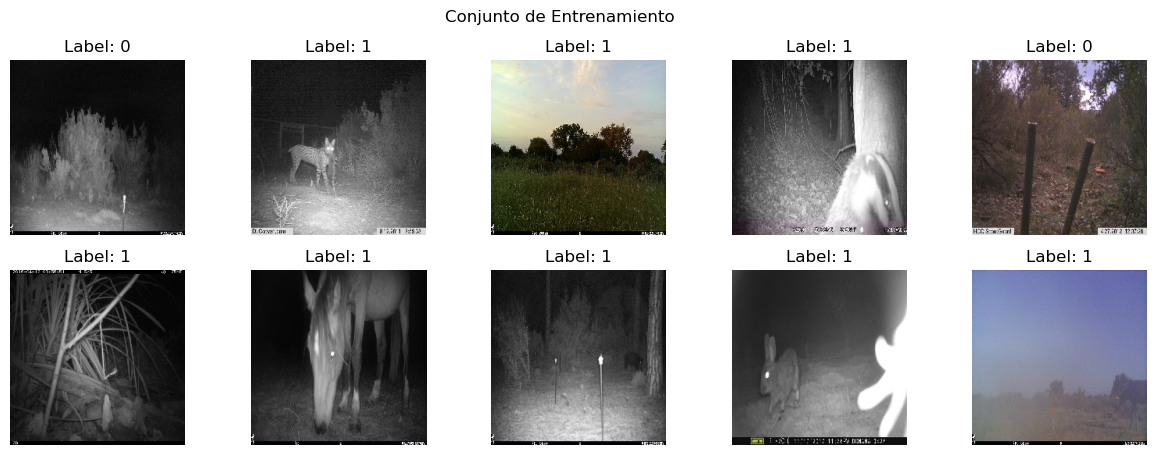

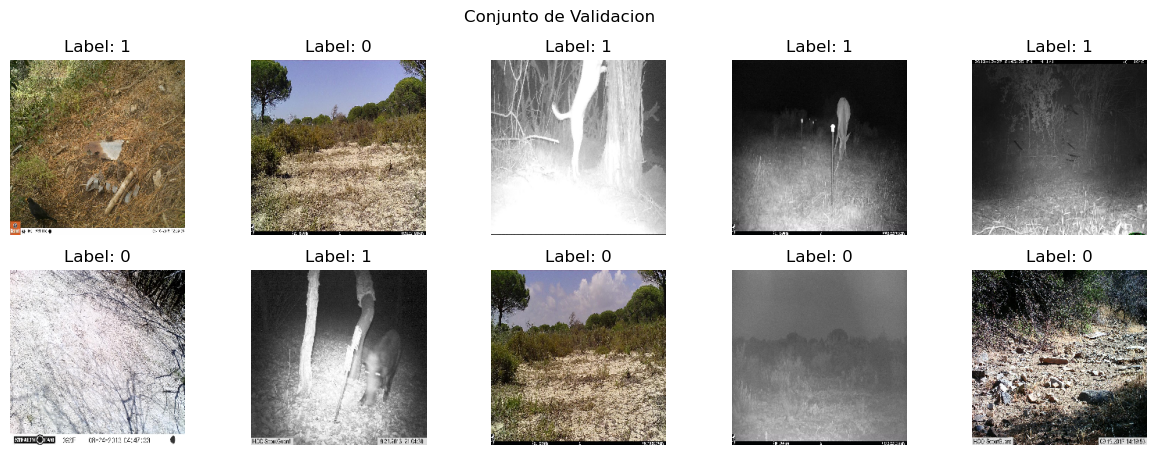

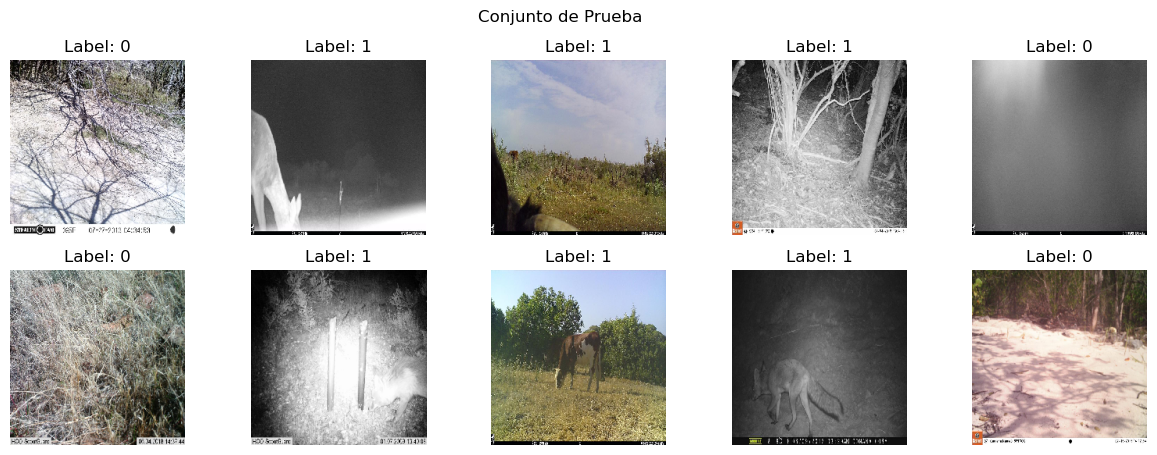

In [75]:
def show_random_images_from_generator(generator, title):
    images, labels = next(generator)
    # Asegúrate de que las imágenes estén en el rango [0, 1] para visualizarlas correctamente
    images = (
        images + 1
    ) * 127.5  # Si las imágenes están en el rango [-1, 1], esto las lleva a [0, 255]
    images = np.clip(images, 0, 255)  # Asegúrate de que no haya valores fuera de rango

    plt.figure(figsize=(15, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(
            images[i].astype("uint8")
        )  # Convierte a enteros de 8 bits para la visualización
        plt.title(f"Label: {int(labels[i])}")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()


show_random_images_from_generator(train_images, "Conjunto de Entrenamiento")
show_random_images_from_generator(validation_images, "Conjunto de Validacion")
show_random_images_from_generator(test_images, "Conjunto de Prueba")

In [76]:
base_model = tensorflow.keras.applications.MobileNetV2(
    weights="imagenet", include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base_model.trainable = False

# Construir el modelo básico
model = tensorflow.keras.models.Sequential(
    [
        base_model,
        tensorflow.keras.layers.GlobalAveragePooling2D(),
        tensorflow.keras.layers.Dense(1, activation="sigmoid"),
    ],
    name=f"MobileNetV2_v.{VERSION}",
)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        "binary_accuracy",
        Precision(name="presision"),
        Recall(name="recall"),
        AUC(name="auc"),
        TruePositives(name="tp"),
        FalsePositives(name="fp"),
        TrueNegatives(name="tn"),
        FalseNegatives(name="fn"),
    ],
)

model.summary()

Model: "MobileNetV2_v.1.0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_7  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_7 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [56]:
history = model.fit(
    train_images,
    validation_data=validation_images,
    epochs=EPOCHS,
    callbacks=[TensorBoard(log_dir=f"./logs/MobileNetV2/v.{VERSION}")],
)

Epoch 1/2


2024-12-04 21:24:44.676292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - ETA: 0s - loss: 0.3122 - accuracy: 0.8602 - binary_accuracy: 0.8602 - presision: 0.8865 - recall: 0.9046 - auc: 0.9329 - tp: 11970.0000 - fp: 1533.0000 - tn: 5232.0000 - fn: 1263.0000

2024-12-04 21:26:09.861150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 104s 165ms/step - loss: 0.3122 - accuracy: 0.8602 - binary_accuracy: 0.8602 - presision: 0.8865 - recall: 0.9046 - auc: 0.9329 - tp: 11970.0000 - fp: 1533.0000 - tn: 5232.0000 - fn: 1263.0000 - val_loss: 0.2463 - val_accuracy: 0.8973 - val_binary_accuracy: 0.8973 - val_presision: 0.9233 - val_recall: 0.9213 - val_auc: 0.9592 - val_tp: 2612.0000 - val_fp: 217.0000 - val_tn: 1232.0000 - val_fn: 223.0000
Epoch 2/2
625/625 [==============================] - 105s 168ms/step - loss: 0.2407 - accuracy: 0.8942 - binary_accuracy: 0.8942 - presision: 0.9186 - recall: 0.9218 - auc: 0.9610 - tp: 12198.0000 - fp: 1081.0000 - tn: 5684.0000 - fn: 1035.0000 - val_loss: 0.2298 - val_accuracy: 0.9050 - val_binary_accuracy: 0.9050 - val_presision: 0.9434 - val_recall: 0.9111 - val_auc: 0.9661 - val_tp: 2583.0000 - val_fp: 155.0000 - val_tn: 1294.0000 - val_fn: 252.0000


In [ ]:
model.save(f"./models/MobileNetV2/MobileNetV2_v.{VERSION}.h5")

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.to_csv(
    f"./logs/MobileNetV2/v.{VERSION}/train_validation_history.csv", index=False
)
history.history

{'loss': [0.3121820390224457, 0.24065890908241272],
 'accuracy': [0.8601860404014587, 0.8941894173622131],
 'binary_accuracy': [0.8601860404014587, 0.8941894173622131],
 'presision': [0.8864696621894836, 0.9185932874679565],
 'recall': [0.9045568108558655, 0.9217864274978638],
 'auc': [0.9329190254211426, 0.9609509706497192],
 'tp': [11970.0, 12198.0],
 'fp': [1533.0, 1081.0],
 'tn': [5232.0, 5684.0],
 'fn': [1263.0, 1035.0],
 'val_loss': [0.24631783366203308, 0.22978591918945312],
 'val_accuracy': [0.8972922563552856, 0.904995322227478],
 'val_binary_accuracy': [0.8972922563552856, 0.904995322227478],
 'val_presision': [0.9232944250106812, 0.943389356136322],
 'val_recall': [0.9213404059410095, 0.9111111164093018],
 'val_auc': [0.9591912031173706, 0.9661388993263245],
 'val_tp': [2612.0, 2583.0],
 'val_fp': [217.0, 155.0],
 'val_tn': [1232.0, 1294.0],
 'val_fn': [223.0, 252.0]}

In [ ]:
results = history.model.evaluate(test_images)
# Nombres de las métricas
metric_names = history.model.metrics_names

# Crear un diccionario con las métricas y los valores
evaluation_results = {
    ("test_" + name): value for name, value in zip(metric_names, results)
}
evaluation_df = pd.DataFrame(evaluation_results)
evaluation_df.to_csv(f"./logs/MobileNetV2/v.{VERSION}/test_history.csv", index=False)
evaluation_results


134/134 [==============================] - 18s 136ms/step - loss: 0.2322 - accuracy: 0.8934 - binary_accuracy: 0.8934 - presision: 0.9337 - recall: 0.9031 - auc: 0.9648 - tp: 2562.0000 - fp: 182.0000 - tn: 1269.0000 - fn: 275.0000


{'loss': 0.23224250972270966,
 'accuracy': 0.8934234976768494,
 'binary_accuracy': 0.8934234976768494,
 'presision': 0.9336734414100647,
 'recall': 0.9030666351318359,
 'auc': 0.9648048877716064,
 'tp': 2562.0,
 'fp': 182.0,
 'tn': 1269.0,
 'fn': 275.0}